# Wind Turbine Power Prediction

In this study I am going to predict a wind turbine power production by using the wind speed, wind direction, month and hour data.

The dataset consists of 50530 observations. In order to demonstrate my data science skills with big data, I am going to use Pyspark library.

The dataset contains:

* Date/Time (for 10 minutes intervals)
* LV ActivePower (kW): The power generated by the turbine for that moment
* Wind Speed (m/s): The wind speed at the hub height of the turbine (the wind speed that turbine use for electricity generation)
* TheoreticalPowerCurve (KWh): The theoretical power values that the turbine generates with that wind speed which is given by the turbine manufacturer
* Wind Direction (°): The wind direction at the hub height of the turbine (wind turbines turn to this direction automaticly)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Aim of the Study:

**My aim is to predict wind turbine power production from the wind speed, wind direction, month of the year and the hour of the day.** 

## Importing Libraries and Spark Configuration

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
# Downloading pyspark library
! pip install pyspark

In [ ]:
# Importing pyspark libraries
import pyspark
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark import SparkContext

# Configuration of Spark Session
spark = SparkSession.builder.master("local").appName("BDP_Project").getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local appName=BDP_Project>

## Reading the Dataset

In [ ]:
# Reading the dataset as Spark DataFrame
spark_df = spark.read.csv('/content/drive/MyDrive/BIG_DATA/Project_2/T1.csv', header=True, inferSchema=True)

# Caching the dataset
spark_df.cache()

# Converting all the column names to lower case
spark_df = spark_df.toDF(*[c.lower() for c in spark_df.columns])

print('Show the first 5 rows')
print(spark_df.show(5))
print()
print('What are the variable data types?')
print(spark_df.printSchema())
print()
print('How many observations do we have?')
print(spark_df.count())

Show the first 5 rows
+----------------+-------------------+----------------+-----------------------------+------------------+
|       date/time|lv activepower (kw)|wind speed (m/s)|theoretical_power_curve (kwh)|wind direction (°)|
+----------------+-------------------+----------------+-----------------------------+------------------+
|01 01 2018 00:00|   380.047790527343|5.31133604049682|             416.328907824861|  259.994903564453|
|01 01 2018 00:10|    453.76919555664|5.67216682434082|             519.917511061494|   268.64111328125|
|01 01 2018 00:20|   306.376586914062|5.21603679656982|             390.900015810951|  272.564788818359|
|01 01 2018 00:30|   419.645904541015|5.65967416763305|             516.127568975674|  271.258087158203|
|01 01 2018 00:40|   380.650695800781|5.57794094085693|             491.702971953588|  265.674285888671|
+----------------+-------------------+----------------+-----------------------------+------------------+
only showing top 5 rows

None

Wh

In [ ]:
# Extracting a substring from columns to create month and hour variables

from pyspark.sql.functions import substring
spark_df = spark_df.withColumn("month", substring("date/time", 4,2))
spark_df = spark_df.withColumn("hour", substring("date/time", 12,2))

# Converting string month and hour variables to integer
from pyspark.sql.types import IntegerType
spark_df = spark_df.withColumn('month', spark_df.month.cast(IntegerType()))
spark_df = spark_df.withColumn('hour', spark_df.hour.cast(IntegerType()))

print(spark_df.show(5))

+----------------+-------------------+----------------+-----------------------------+------------------+-----+----+
|       date/time|lv activepower (kw)|wind speed (m/s)|theoretical_power_curve (kwh)|wind direction (°)|month|hour|
+----------------+-------------------+----------------+-----------------------------+------------------+-----+----+
|01 01 2018 00:00|   380.047790527343|5.31133604049682|             416.328907824861|  259.994903564453|    1|   0|
|01 01 2018 00:10|    453.76919555664|5.67216682434082|             519.917511061494|   268.64111328125|    1|   0|
|01 01 2018 00:20|   306.376586914062|5.21603679656982|             390.900015810951|  272.564788818359|    1|   0|
|01 01 2018 00:30|   419.645904541015|5.65967416763305|             516.127568975674|  271.258087158203|    1|   0|
|01 01 2018 00:40|   380.650695800781|5.57794094085693|             491.702971953588|  265.674285888671|    1|   0|
+----------------+-------------------+----------------+-----------------

## Exploratory Data Analysis

In [ ]:
pd.options.display.float_format = '{:.2f}'.format
spark_df.select('wind speed (m/s)', 'theoretical_power_curve (kwh)', 'lv activepower (kw)').toPandas().describe()

,wind speed (m/s),theoretical_power_curve (kwh),lv activepower (kw)
count,50530.00,50530.00,50530.00
mean,7.56,1492.18,1307.68
std,4.23,1368.02,1312.46
min,0.00,0.00,-2.47
25%,4.20,161.33,50.68
50%,7.10,1063.78,825.84
75%,10.30,2964.97,2482.51
max,25.21,3600.00,3618.73


### Question: What are the distributions of the variables?

**For creating visualization we need to either use aggregated data or use a sample from the big data.**

**So I will get a random sample from my big data.**

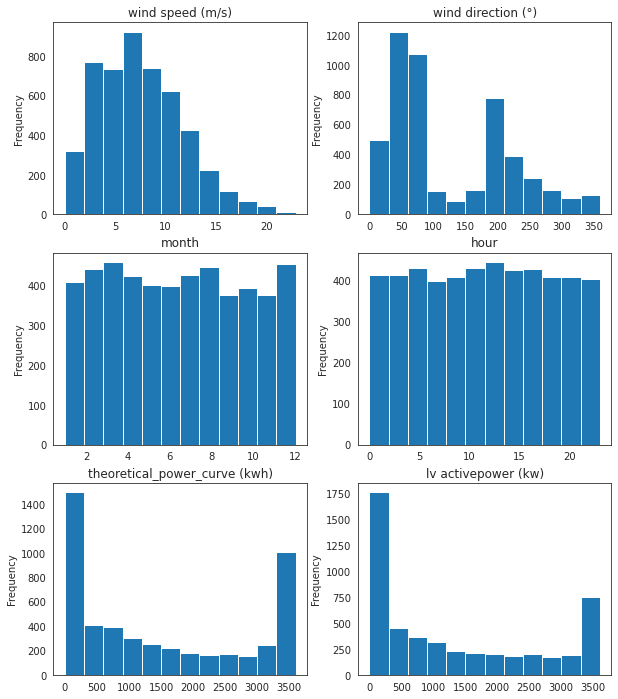

In [ ]:
# Taking a random sample from the big data
sample_df = spark_df.sample(withReplacement=False, fraction=0.1, seed=42).toPandas()

# Visualizing the distributions with the sample data
columns = ['wind speed (m/s)', 'wind direction (°)', 'month', 'hour', 'theoretical_power_curve (kwh)', 'lv activepower (kw)']
i=1
plt.figure(figsize=(10,12))
for each in columns:
    plt.subplot(3,2,i)
    sample_df[each].plot.hist(bins=12)
    plt.title(each)
    i += 1


### Question: Is there any difference between the months for average power production ?

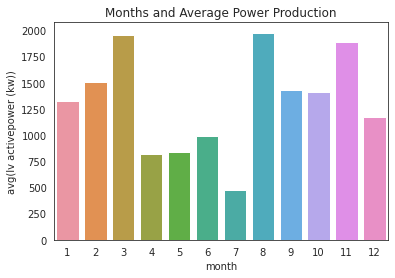

In [ ]:
# Average power production by month
monthly = spark_df.groupby('month').mean('lv activepower (kw)').sort('avg(lv activepower (kw))').toPandas()
sns.barplot(x='month', y='avg(lv activepower (kw))', data=monthly)
plt.title('Months and Average Power Production');

### Question: Is there any difference between the hours for average power production?

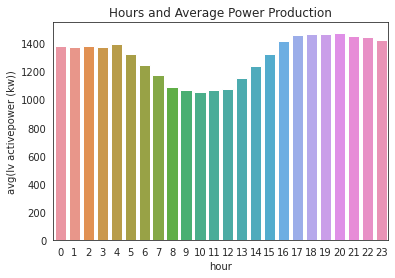

In [ ]:
# Average power production by hour
hourly = spark_df.groupby('hour').mean('lv activepower (kw)').sort('avg(lv activepower (kw))').toPandas()
sns.barplot(x='hour', y='avg(lv activepower (kw))', data=hourly)
plt.title('Hours and Average Power Production');

### Question: Is there any correlation between the wind speed, wind direction and power production?

,wind speed (m/s),wind direction (°),month,hour,theoretical_power_curve (kwh),lv activepower (kw)
wind speed (m/s),1.00,-0.08,-0.01,0.03,0.95,0.91
wind direction (°),-0.08,1.00,-0.18,0.00,-0.11,-0.06
month,-0.01,-0.18,1.00,-0.01,-0.00,0.04
hour,0.03,0.00,-0.01,1.00,0.03,0.03
theoretical_power_curve (kwh),0.95,-0.11,-0.00,0.03,1.00,0.94
lv activepower (kw),0.91,-0.06,0.04,0.03,0.94,1.00


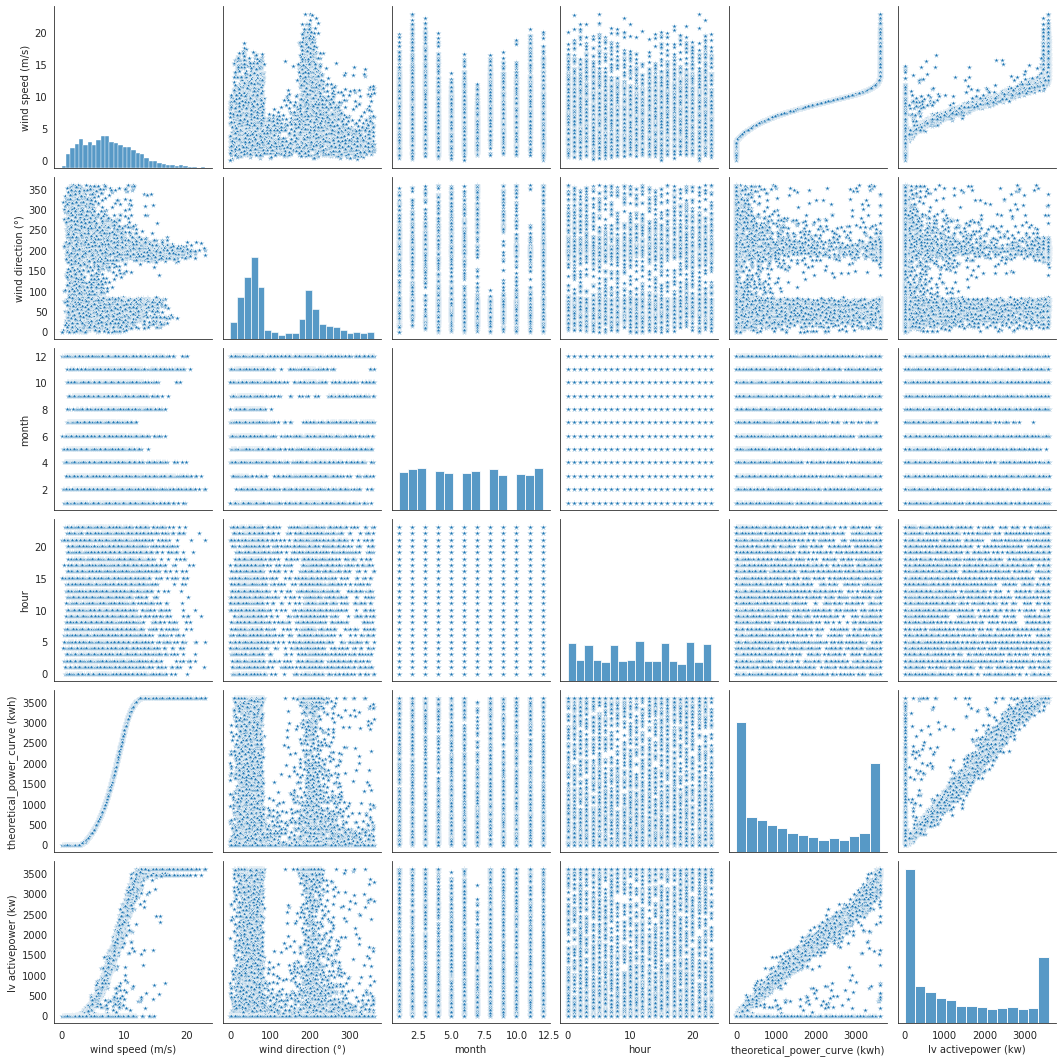

In [ ]:
display(sample_df[columns].corr())
sns.pairplot(sample_df[columns], markers='*');

**Wind speed and power production is highly correlated as one would expect.**

**We can see there are lower level power production for some wind directions.**

### Question: What is the average power production level for different wind speeds?

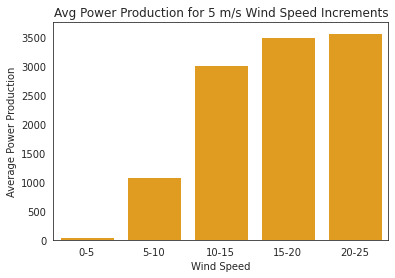

In [ ]:
# Finding average power production for 5 m/s wind speed increments
wind_speed = []
avg_power = []
for i in [0,5,10,15,20]:
    avg_value = spark_df.filter((spark_df['wind speed (m/s)'] > i) 
                                & (spark_df['wind speed (m/s)'] <= i+5))\
                                .agg({'lv activepower (kw)':'mean'}).collect()[0][0] 
    avg_power.append(avg_value)
    wind_speed.append(str(i) + '-' + str(i+5))

sns.barplot(x=wind_speed, y=avg_power, color='orange')
plt.title('Avg Power Production for 5 m/s Wind Speed Increments')
plt.xlabel('Wind Speed')
plt.ylabel('Average Power Production');

**From the graph above we can see the power production reaches near a maximum level after the wind speed reaches 15 m/s.**

### Question: What is the power production for different wind directions and speeds? 

**Let's create a polar diagram with wind speed, wind direction and power production from the sample data.**

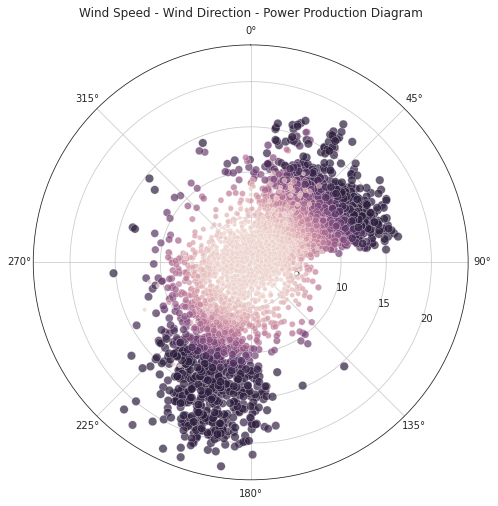

In [ ]:
# Creating the polar diagram
from math import radians

plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)
# Inside circles are the wind speed and marker color and size represents the amount of power production
sns.scatterplot(x=[radians(x) for x in sample_df['wind direction (°)']], 
                y=sample_df['wind speed (m/s)'],
                size=sample_df['lv activepower (kw)'],
                hue=sample_df['lv activepower (kw)'],
                alpha=0.7, legend=None)
# Setting the polar diagram's top represents the North 
ax.set_theta_zero_location('N')
# Setting -1 to start the wind direction clockwise
ax.set_theta_direction(-1)
# Setting wind speed labels in a better position to see
ax.set_rlabel_position(110)
plt.title('Wind Speed - Wind Direction - Power Production Diagram')
plt.ylabel(None);

**We can see that the wind turbine produces more power if the wind blows from the directions between 000-090 and 180-225 degrees.**

### Question: Does the manufacturer's theoritical power production curve fit well with the real production?

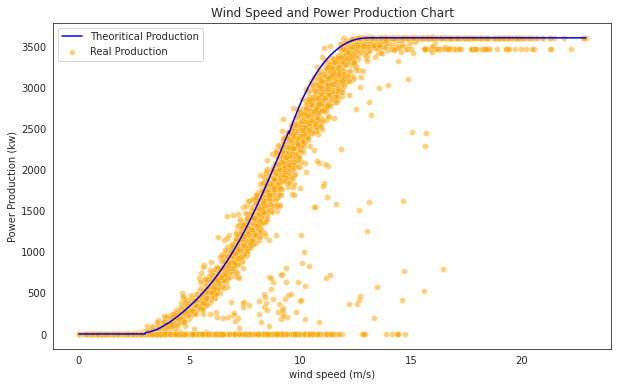

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='wind speed (m/s)', y='lv activepower (kw)', color='orange', label='Real Production', alpha=0.5, data=sample_df)
sns.lineplot(x='wind speed (m/s)', y='theoretical_power_curve (kwh)', color='blue', label='Theoritical Production', data=sample_df)
plt.title('Wind Speed and Power Production Chart')
plt.ylabel('Power Production (kw)');

**From the graph above, we can see the theoritical power production curve generally fits well with the real production.**

**We can see the power production reaches a maximum level and continues in a straight line if the wind speed reaches to 15 m/s.**

**Also we can see there are some 0 power production, even the wind speed is higher than 5 m/s. I want to investigate the reason.**

**But before what is the minimum wind speed for theoritical power production curve?**

### Question: What is the wind speed threshold value for zero theorical power?

,wind speed (m/s),theoretical_power_curve (kwh),lv activepower (kw)
2295,1.24,0.00,0.00
2824,1.66,0.00,0.00
6319,1.51,0.00,0.00
4835,1.53,0.00,0.00
6254,1.96,0.00,0.00


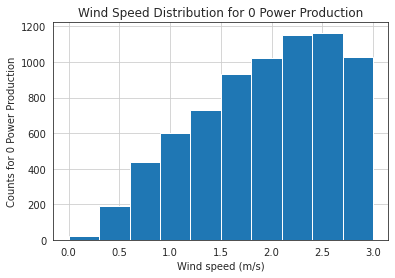

In [ ]:
# Filter the big data where the real and theoritical power productions are equal to 0
zero_theo_power = spark_df.filter((spark_df['lv activepower (kw)'] == 0)
                                  & (spark_df['theoretical_power_curve (kwh)'] == 0)).toPandas()

display(zero_theo_power[['wind speed (m/s)', 'theoretical_power_curve (kwh)', 'lv activepower (kw)']].sample(5))

# Let's see the wind speed distribution for 0 power production
zero_theo_power['wind speed (m/s)'].hist()
plt.title('Wind Speed Distribution for 0 Power Production')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Counts for 0 Power Production');

**We can see from above, limit for the theoritical power curve is 3 m/s wind speed. If the wind speed is below 3 m/s model doesn't expect any power production.**

**But there are some observations for 0 power production even the wind speed is more than 3 m/s.**

### Question: Why there aren't any power production in some observations while the wind speed is higher than 3 m/s?

In [ ]:
# Observations for the wind speed > 3m/s and power production = 0, 
# While theoritically there should be power production
zero_power = spark_df.filter((spark_df['lv activepower (kw)'] == 0)
                            & (spark_df['theoretical_power_curve (kwh)'] != 0)
                            & (spark_df['wind speed (m/s)'] > 3)).toPandas()
display(zero_power.head())
print('No of Observations (while Wind Speed > 3 m/s and Power Production = 0): ', len(zero_power))

,date/time,lv activepower (kw),wind speed (m/s),theoretical_power_curve (kwh),wind direction (°),month,hour
0,03 01 2018 15:40,0.00,3.74,83.99,245.07,1,15
1,03 01 2018 16:40,0.00,3.03,17.18,221.09,1,16
2,03 01 2018 16:50,0.00,3.20,25.43,232.68,1,16
3,03 01 2018 17:00,0.00,3.91,110.98,241.97,1,17
4,04 01 2018 13:50,0.00,3.44,45.74,79.09,1,13


No of Observations (while Wind Speed > 3 m/s and Power Production = 0):  3497


**There are 3497 observations where theoritically there should be power production. From the dataset we cannot see the reason, it might be caused by maintenance. But let's see if we can see any information from the wind speed, direction and month?**

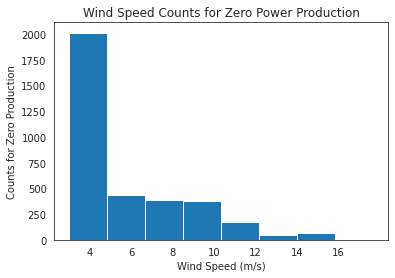

In [ ]:
zero_power['wind speed (m/s)'].plot.hist(bins=8)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Counts for Zero Production')
plt.title('Wind Speed Counts for Zero Power Production')
plt.xticks(ticks=np.arange(4,18,2));

**It looks like theoritically wind speed threshold should be 4 m/s. But there are also other observations with zero power production while the wind speed is higher.**

**Let's see the monthly distribution for zero power production.**

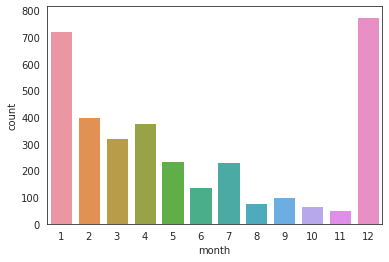

In [ ]:
sns.countplot(zero_power['month']);

**It is usually in December and January when the wind turbine doesn't produce production.**

**Because I cannot decide if these zero power productions are caused by maintenance periods or something else, I am going to accept those 3497 observations as outliers and remove them from the dataset.**

In [ ]:
# Excluding the observations meeting the filter criterias 
spark_df = spark_df.filter(~((spark_df['lv activepower (kw)'] == 0)
                            & (spark_df['theoretical_power_curve (kwh)'] != 0)
                            & (spark_df['wind speed (m/s)'] > 3)))

### Question: Is there any other outliers?

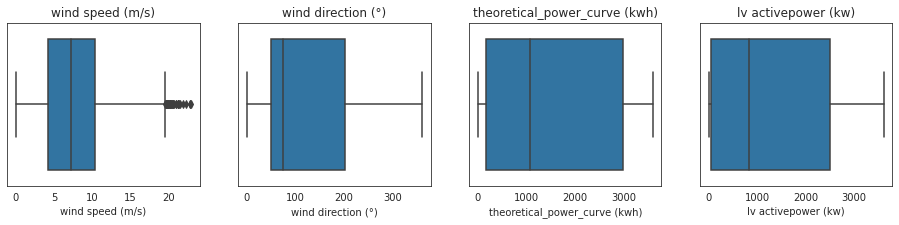

In [ ]:
columns = ['wind speed (m/s)', 'wind direction (°)', 'theoretical_power_curve (kwh)', 'lv activepower (kw)']
i=1
plt.figure(figsize=(20,3))
for each in columns:
    plt.subplot(1,5,i)
    sns.boxplot(sample_df[each])
    plt.title(each)
    i += 1

**From the graphs above I can see there are some outliers in the wind speed data.**

**I will find the upper and lower threshold values for the wind speed data, and I will analyze the outliers.**

In [ ]:
# Create a pandas df for visualization
wind_speed = spark_df.select('wind speed (m/s)').toPandas()

# Defining the quantiles and interquantile range
Q1 = wind_speed['wind speed (m/s)'].quantile(0.25)
Q3 = wind_speed['wind speed (m/s)'].quantile(0.75)
IQR = Q3-Q1
# Defining the lower and upper threshold values
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

print('Quantile (0.25): ', Q1, '  Quantile (0.75): ', Q3)
print('Lower threshold: ', lower, ' Upper threshold: ', upper)

Quantile (0.25):  4.45584678649902   Quantile (0.75):  10.4771900177001
Lower threshold:  -4.576168060302599  Upper threshold:  19.50920486450172


In [ ]:
# Fancy indexing for outliers
outlier_tf = (wind_speed['wind speed (m/s)'] < lower) | (wind_speed['wind speed (m/s)'] > upper)

print('Total Number of Outliers: ', len(wind_speed['wind speed (m/s)'][outlier_tf]))
print('--'*15)
print('Some Examples of Outliers:')
print(wind_speed['wind speed (m/s)'][outlier_tf].sample(10))

Total Number of Outliers:  407
------------------------------
Some Examples of Outliers:
3241   20.30
3530   23.41
2532   22.00
7506   19.95
3259   23.46
2112   19.72
7450   19.75
2523   20.27
8899   19.52
3572   20.48
Name: wind speed (m/s), dtype: float64


**It is a rare event for wind speed to be over 19 m/s in our dataset.**

**Out of 47033, there is only 407 observations while the wind speed is over 19 m/s.**

**Now I want to see average power production for these high wind speed.**

In [ ]:
spark_df.select('wind speed (m/s)', 'lv activepower (kw)')\
.filter(spark_df['wind speed (m/s)'] >= 19)\
.agg({'lv activepower (kw)':'mean'}).show()

+------------------------+
|avg(lv activepower (kw))|
+------------------------+
|      3566.4634427974706|
+------------------------+



**So instead of erasing the outliers, I am going to set the wind speed as 19 m/s for those observations.**

In [ ]:
from pyspark.sql import functions as F
spark_df = spark_df.withColumn('wind speed (m/s)', 
                               F.when(F.col('wind speed (m/s)') > 19.447, 19)
                               .otherwise(F.col('wind speed (m/s)')))
spark_df.count()

47033

### Question: What are the general criterias for power production?

**It is important to understand the pattern in the data. We should learn the data before the machine.**

**1. We saw from the graph that in March, August and November, the average power production is higher.**

**2. The average power production is higher daily between 16:00 and 24:00.**

**3. The power production is higher when the wind blows from the directions between 000-090 and 180-225 degrees.**

**So let's try to predict a high and low level of power production from the criterias above before ML algorithm.**

In [ ]:
# High level power production
spark_df.filter(((spark_df['month'] == 3) | (spark_df['month'] == 8) | (spark_df['month'] == 11)) 
                & ((spark_df['hour'] >= 16) | (spark_df['hour'] <= 24)) 
                & ((spark_df['wind direction (°)'] > 0) | (spark_df['wind direction (°)'] < 90))
                & ((spark_df['wind direction (°)'] > 180) | (spark_df['wind direction (°)'] < 225))
               ).agg({'lv activepower (kw)':'mean'}).show()

+------------------------+
|avg(lv activepower (kw))|
+------------------------+
|      2013.4446757880403|
+------------------------+



In [ ]:
# Low level power production
spark_df.filter((spark_df['month'] == 7) 
                & ((spark_df['hour'] >= 9) | (spark_df['hour'] <= 11)) 
                & ((spark_df['wind direction (°)'] > 90) | (spark_df['wind direction (°)'] < 160))
               ).agg({'lv activepower (kw)':'mean'}).show()

+------------------------+
|avg(lv activepower (kw))|
+------------------------+
|       503.1644205414878|
+------------------------+



## Data Preparation for ML Algorithms

**After analysing and understanding the dataset, we can build a ML regression model to predict wind turbine power production by using the wind speed, wind direction, month of the year and hour of the day.**

**Using ML algorithms with Spark is a bit different from well known Sckitlearn library.**

**We need to feed the model with a dataframe made of variables compressed in vectors called as 'features', and target variable as 'label'. For these convertions I am going to use VectorAssembler method from Pyspark.**

In [ ]:
# Preparing the independent variables (Features)
from pyspark.ml.feature import VectorAssembler

# Converting lv activepower (kw) variable as label
spark_df = spark_df.withColumn('label', spark_df['lv activepower (kw)'])

# Defining the variables to be used
variables = ['month', 'hour', 'wind speed (m/s)', 'wind direction (°)']
vectorAssembler = VectorAssembler(inputCols = variables, outputCol = 'features')
va_df = vectorAssembler.transform(spark_df)

# Combining features and label column
final_df = va_df.select('features', 'label')
final_df.show(10)

+--------------------+----------------+
|            features|           label|
+--------------------+----------------+
|[1.0,0.0,5.311336...|380.047790527343|
|[1.0,0.0,5.672166...| 453.76919555664|
|[1.0,0.0,5.216036...|306.376586914062|
|[1.0,0.0,5.659674...|419.645904541015|
|[1.0,0.0,5.577940...|380.650695800781|
|[1.0,0.0,5.604052...|402.391998291015|
|[1.0,1.0,5.793007...|447.605712890625|
|[1.0,1.0,5.306049...|     387.2421875|
|[1.0,1.0,5.584629...|463.651214599609|
|[1.0,1.0,5.523228...|439.725708007812|
+--------------------+----------------+
only showing top 10 rows



## Train Test Split

**Now we can split our dataset into train and test datasets.**

In [ ]:
splits = final_df.randomSplit([0.8, 0.2])
train_df = splits[0]
test_df = splits[1]

print('Train dataset: ', train_df.count())
print('Test dataset : ', test_df.count())

Train dataset:  37532
Test dataset :  9501


## Creating the Initial Model

**I am going to use GBT regressor for this study.**

In [ ]:
from pyspark.ml.regression import GBTRegressor

# Creating the gbm regressor object
gbm = GBTRegressor(featuresCol='features', labelCol='label')

# Training the model with train data
gbm_model = gbm.fit(train_df)

# Predicting using the test data
y_pred = gbm_model.transform(test_df)

# Initial look at the target and predicted values
y_pred.select('label', 'prediction').show(20)

+----------------+------------------+
|           label|        prediction|
+----------------+------------------+
|             0.0|20.987641826485365|
|296.469909667968| 294.9783430305611|
|368.497009277343|408.09068783453034|
|402.391998291015| 503.4113690799335|
|419.645904541015| 503.4113690799335|
| 453.76919555664| 503.4113690799335|
|685.547424316406| 594.1724876622977|
|837.063720703125| 830.7282842379092|
|989.507690429687| 844.8468539573399|
|1176.72399902343|1002.6135858480549|
|1085.18200683593|1210.7370844761972|
| 1240.9580078125| 1366.465698096589|
|2782.56811523437|2726.7490801791732|
|3083.24389648437|2968.4856546920782|
|3603.39404296875| 3286.824894283904|
|      735.859375|3429.3019291517744|
|1274.19299316406|3429.3019291517744|
|966.777099609375|3429.3019291517744|
|3443.13696289062|3429.3019291517744|
|3602.19409179687| 3519.995510008252|
+----------------+------------------+
only showing top 20 rows



**Let's evaluate our model's success.**

In [ ]:
# Initial model success
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='label')

print('R2 SCORE : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'r2'}))
print('MAE      : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'mae'}))
print('RMSE     : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'rmse'}))

R2 SCORE :  0.9776199337431177
MAE      :  85.53202515452865
RMSE     :  195.32864868410834


**R2 score means, real power production's 97% variability can be explained by the ML model.**

**MAE is the mean absolute difference between the real and predicted power production.**

**RMSE is the square root of mean squared difference between the real and predicted values.**

**Even though the R2 is high, we should also check the MAE and RMSE values with the real value's summary statistics.**

**One can tune the hyperparameters to increase the model success. But I this look good enough for me.**

## Comparing Real, Theoritical and Predicted Power Productions

**I am going to use sample_df for comparing the actual, theoritical and the model power productions.**

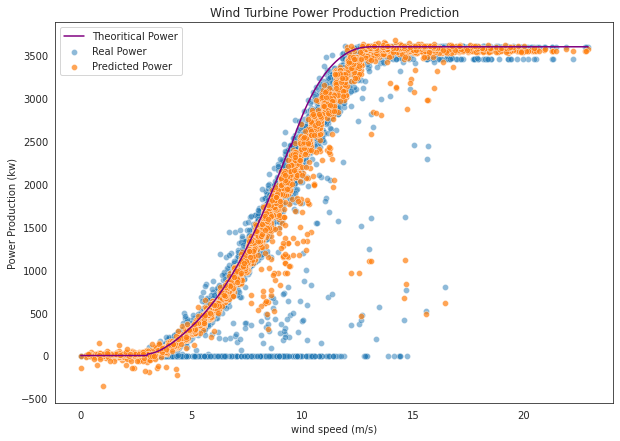

In [ ]:
# Converting sample_df back to Spark dataframe
eva_df = spark.createDataFrame(sample_df)

# Converting lv activepower (kw) variable as label
eva_df = eva_df.withColumn('label', eva_df['lv activepower (kw)'])

# Defining the variables to be used
variables = ['month', 'hour', 'wind speed (m/s)', 'wind direction (°)']
vectorAssembler = VectorAssembler(inputCols = variables, outputCol = 'features')
vec_df = vectorAssembler.transform(eva_df)

# Combining features and label column
vec_df = vec_df.select('features', 'label')

# Using ML model to predict
preds = gbm_model.transform(vec_df)
preds_df = preds.select('label','prediction').toPandas()

# Compining dataframes to compare
frames = [sample_df[['wind speed (m/s)', 'theoretical_power_curve (kwh)']], preds_df]
sample_data = pd.concat(frames, axis=1)

# Visualizing real, theoritical and predicted power production
plt.figure(figsize=(10,7))
sns.scatterplot(x='wind speed (m/s)', y='label',alpha=0.5, label= 'Real Power', data=sample_data)
sns.scatterplot(x='wind speed (m/s)', y='prediction', alpha=0.7, label='Predicted Power', marker='o', data=sample_data)
sns.lineplot(x='wind speed (m/s)', y='theoretical_power_curve (kwh)', label='Theoritical Power',color='purple', data=sample_data)
plt.title('Wind Turbine Power Production Prediction')
plt.ylabel('Power Production (kw)')
plt.legend();

**From the graph above, the model fits better to the real power productions, than the theoritical power production curve.**

In [ ]:
from pyspark.ml.regression import LinearRegression

# Creating the gbm regressor object
gbm = LinearRegression(featuresCol='features', labelCol='label')

# Training the model with train data
gbm_model = gbm.fit(train_df)

# Predicting using the test data
y_pred = gbm_model.transform(test_df)

# Initial look at the target and predicted values
y_pred.select('label', 'prediction').show(20)

+----------------+------------------+
|           label|        prediction|
+----------------+------------------+
|             0.0|-666.8259942025521|
|296.469909667968|  603.965673335214|
|368.497009277343|  729.089305724862|
|402.391998291015| 763.7076042162014|
|419.645904541015| 780.6746628329029|
| 453.76919555664| 784.0429441270765|
|685.547424316406| 863.7385852875175|
|837.063720703125| 967.3607134749952|
|989.507690429687|1093.3120358786452|
|1176.72399902343|1227.9235533292028|
|1085.18200683593|1267.9975802859856|
| 1240.9580078125|1345.5626171631977|
|2782.56811523437|2156.8477599265343|
|3083.24389648437|2448.6313027034803|
|3603.39404296875|2599.9458814446953|
|      735.859375|2683.3444082625574|
|1274.19299316406|2682.8612564379573|
|966.777099609375|2686.5172374272943|
|3443.13696289062| 2778.969710665051|
|3602.19409179687| 2968.020598997603|
+----------------+------------------+
only showing top 20 rows



**Let's evaluate our model's success.**

In [ ]:
# Initial model success
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='label')

print('R2 SCORE : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'r2'}))
print('MAE      : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'mae'}))
print('RMSE     : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'rmse'}))

R2 SCORE :  0.8817341762141907
MAE      :  351.87124207427394
RMSE     :  449.01917976724945


**R2 score means, real power production's 97% variability can be explained by the ML model.**

**MAE is the mean absolute difference between the real and predicted power production.**

**RMSE is the square root of mean squared difference between the real and predicted values.**

**Even though the R2 is high, we should also check the MAE and RMSE values with the real value's summary statistics.**

**One can tune the hyperparameters to increase the model success. But I this look good enough for me.**


## Comparing Real, Theoritical and Predicted Power Productions

**I am going to use sample_df for comparing the actual, theoritical and the model power productions.**

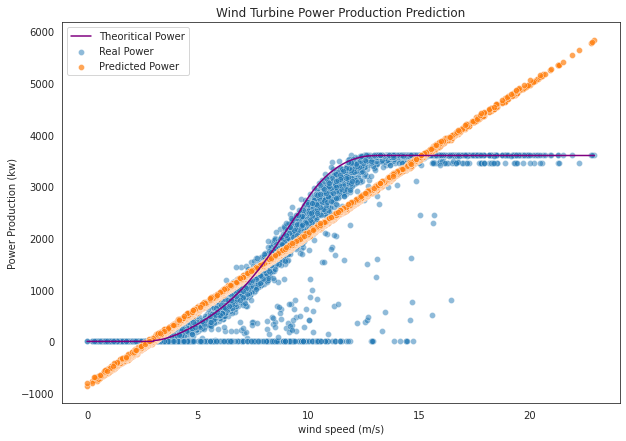

In [ ]:
# Converting sample_df back to Spark dataframe
eva_df = spark.createDataFrame(sample_df)

# Converting lv activepower (kw) variable as label
eva_df = eva_df.withColumn('label', eva_df['lv activepower (kw)'])

# Defining the variables to be used
variables = ['month', 'hour', 'wind speed (m/s)', 'wind direction (°)']
vectorAssembler = VectorAssembler(inputCols = variables, outputCol = 'features')
vec_df = vectorAssembler.transform(eva_df)

# Combining features and label column
vec_df = vec_df.select('features', 'label')

# Using ML model to predict
preds = gbm_model.transform(vec_df)
preds_df = preds.select('label','prediction').toPandas()

# Compining dataframes to compare
frames = [sample_df[['wind speed (m/s)', 'theoretical_power_curve (kwh)']], preds_df]
sample_data = pd.concat(frames, axis=1)

# Visualizing real, theoritical and predicted power production
plt.figure(figsize=(10,7))
sns.scatterplot(x='wind speed (m/s)', y='label',alpha=0.5, label= 'Real Power', data=sample_data)
sns.scatterplot(x='wind speed (m/s)', y='prediction', alpha=0.7, label='Predicted Power', marker='o', data=sample_data)
sns.lineplot(x='wind speed (m/s)', y='theoretical_power_curve (kwh)', label='Theoritical Power',color='purple', data=sample_data)
plt.title('Wind Turbine Power Production Prediction')
plt.ylabel('Power Production (kw)')
plt.legend();